In [1]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

Let's get the images

In [2]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', 
                                   fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
print(data_dir)

C:\Users\fdoli\.keras\datasets\flower_photos


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [6]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt'])
CLASS_NAMES

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

Each directory contains images of the folder's name:

In [10]:
roses = list(data_dir.glob('roses/*'))

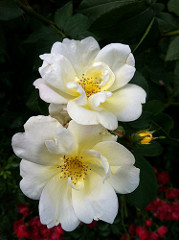

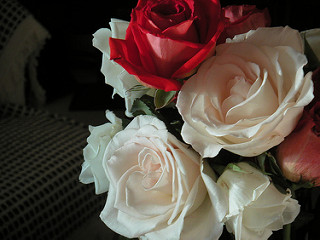

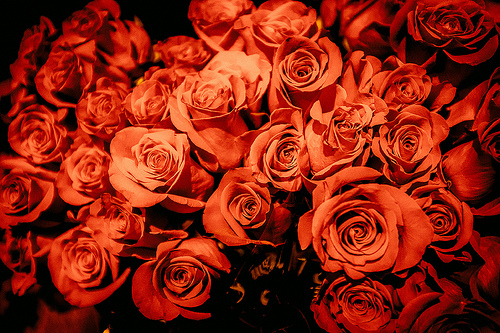

In [11]:
for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## Loading using `keras.preprocessing`  
This is a simple way to load images

In [12]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # the scaling is to get a float32 in range [0,1]

In [13]:
# Parameters for the loader
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [14]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir), 
                                                     batch_size=BATCH_SIZE, 
                                                     shuffle=True, 
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                     classes=list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


Inspect a batch:

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

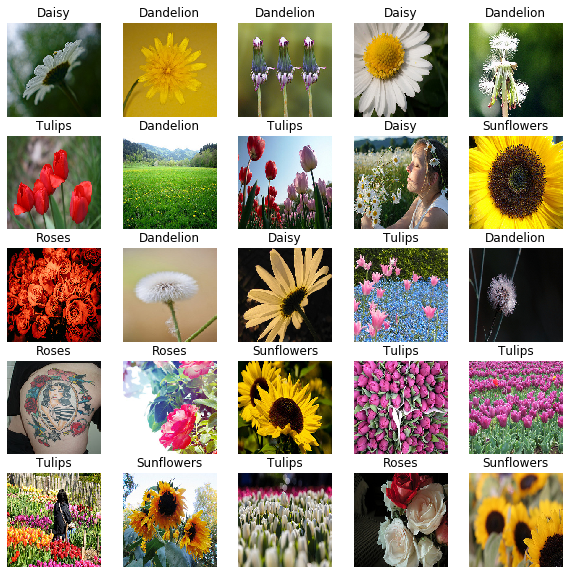

In [17]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Load using `tf.data`  
The previous method has three downsides:
1. It's slow.
2. It lacks fine-grained control.
3. It is not well integrated with the rest of tensorflow (?)

Now, let's load with `tf.data.Dataset`.   
First, we create a dataset of the filepaths:

In [18]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [36]:
len(list(list_ds))

3670

In [19]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\fdoli\\.keras\\datasets\\flower_photos\\roses\\5578760521_e54aca6bed_n.jpg'
b'C:\\Users\\fdoli\\.keras\\datasets\\flower_photos\\tulips\\8686013485_3c4dfbfd1f_n.jpg'
b'C:\\Users\\fdoli\\.keras\\datasets\\flower_photos\\roses\\20825078671_90b0389c70_m.jpg'
b'C:\\Users\\fdoli\\.keras\\datasets\\flower_photos\\sunflowers\\5032376020_2ed312306c.jpg'
b'C:\\Users\\fdoli\\.keras\\datasets\\flower_photos\\roses\\5182167964_9d1a0be0b8_n.jpg'


Now write a short pure-tensorflow function that converts a file paths to an (image_data, label) pair:

In [20]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    
    # the second to last is the calss-directory
    return parts[-2] == CLASS_NAMES

In [21]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Use 'convert_image_dtype' to convert to floats in the [0,1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # resize the image to the desired size
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [22]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [24]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel
AUTOTUNE = tf.data.experimental.AUTOTUNE
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
for image, label in labeled_ds.take(1):
    print('Image shape: ', image.numpy().shape)
    print('label: ', label.numpy())

Image shape:  (224, 224, 3)
label:  [False False False False  True]


Nice, we can load an image and get its label.  

## Basic methods for training  
To train a model with this dataset you will want the data:
- To be welll shuffled
- To be batched
- Batches to be available as soon as possible  

These features can be easily added using the `tf.data` api.

In [26]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
    # Repeat forever
    ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE)
    
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [27]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

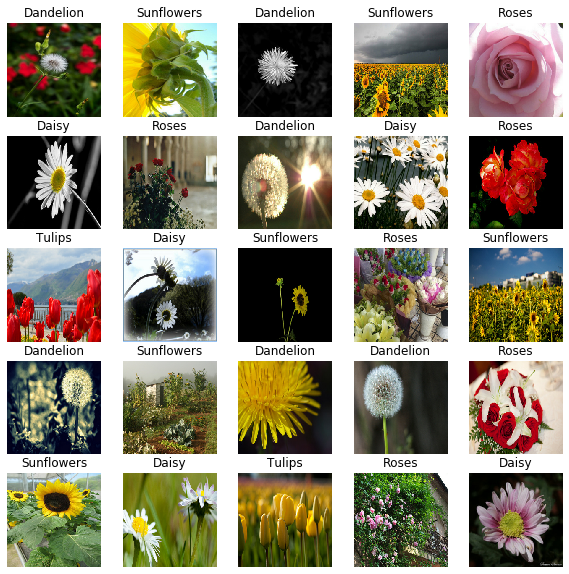

In [28]:
show_batch(image_batch.numpy(), label_batch.numpy())

# Comparring Performance  

Here is a function to check the performance of the datasets:

In [30]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
    start = time.time()
    it = iter(ds)
    for i in range(steps):
        batch = next(it)
        if i%10 == 0:
            print('.', end='')
    print()
    end = time.time()
    
    duration = end - start
    print('{} batches: {} s'.format(steps, duration))
    print('{:0.5f} Images/s'.format(BATCH_SIZE * steps / duration))

Now we can compare the speed of the generators:

In [32]:
# `keras.preprocessing`
timeit(train_data_gen)

....................................................................................................
1000 batches: 176.97832441329956 s
180.81310 Images/s


In [33]:
# `tf.data`
timeit(train_ds)

....................................................................................................
1000 batches: 48.83879590034485 s
655.21681 Images/s


Without using a cache, the second generator is slower

In [34]:
unchaches_ds = prepare_for_training(labeled_ds, cache=False)
timeit(unchaches_ds)

....................................................................................................
1000 batches: 87.36973690986633 s
366.25954 Images/s
